In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support

random seeds for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Configuration

In [4]:
CONFIG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'EPOCHS': 30,
    'FINE_TUNE_EPOCHS': 10,
    'OPTIMIZER': 'adam',
    'LOSS': 'categorical_crossentropy',
    'TRAIN_SPLIT': 0.7,
    'VAL_SPLIT': 0.15,
    'TEST_SPLIT': 0.15,
    'LEARNING_RATE': 1e-3,
    'FINE_TUNE_LR': 1e-5
}

Load And Split

In [5]:
def load_and_split_dataset(csv_path, image_dir, output_dir='flavia_split'):

    print("\n" + "="*80)
    print("STEP 1: LOADING DATASET FROM CSV AND SPLITTING")
    print("="*80)


    df = pd.read_csv(csv_path)
    print(f"✓ Loaded CSV with {len(df)} images")

    
    unique_classes = np.array(sorted(df['y'].unique()))
    num_classes = len(unique_classes)
    print(f"✓ Found {num_classes} classes (0-{max(unique_classes)})")

  
    print("\nClass Distribution:")
    class_counts = df['y'].value_counts().sort_index()
    for class_id, count in class_counts.items():
        print(f"  Class {class_id}: {count} samples")

    
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=np.array(df['y'].values)
    )
    class_weight_dict = dict(zip(unique_classes.tolist(), class_weights))
    print(f"\n✓ Computed class weights to handle imbalance")

    
    splits = ['train', 'val', 'test']
    for split in splits:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
        for class_id in unique_classes:
            class_dir = os.path.join(output_dir, split, str(class_id))
            os.makedirs(class_dir, exist_ok=True)

    total_copied = 0
    split_counts = {'train': 0, 'val': 0, 'test': 0}

    for class_id in unique_classes:
        class_images = df[df['y'] == class_id].copy()

        
        train_imgs, temp_imgs = train_test_split(
            class_images,
            train_size=CONFIG['TRAIN_SPLIT'],
            random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            train_size=0.5,  
            random_state=42
        )

        
        for split, img_df in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            for _, row in img_df.iterrows():
                img_file = row['id']
                src = os.path.join(image_dir, img_file)
                dst = os.path.join(output_dir, split, str(class_id), img_file)

                if os.path.exists(src):
                    shutil.copy2(src, dst)
                    split_counts[split] += 1
                    total_copied += 1

    print(f"\n✓ Dataset split complete!")
    print(f"  Total images copied: {total_copied}")
    print(f"  Training: {split_counts['train']} ({split_counts['train']/total_copied*100:.1f}%)")
    print(f"  Validation: {split_counts['val']} ({split_counts['val']/total_copied*100:.1f}%)")
    print(f"  Test: {split_counts['test']} ({split_counts['test']/total_copied*100:.1f}%)")

    return output_dir, class_weight_dict, unique_classes

Create Data Generators

In [6]:
def create_data_generators(data_dir):

    print("\n" + "="*80)
    print("STEP 2: CREATING DATA GENERATORS WITH AUGMENTATION")
    print("="*80)

    
    train_datagen = ImageDataGenerator(
        rescale=1./255,              
        rotation_range=40,            
        zoom_range=0.3,             
        horizontal_flip=True,         
        vertical_flip=True,           
        shear_range=0.2,            
        brightness_range=[0.8, 1.2], 
        fill_mode='nearest'
    )

    
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='categorical',
        shuffle=False
    )

    print(f"\n✓ Data generators created:")
    print(f"  Image size: {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']}")
    print(f"  Batch size: {CONFIG['BATCH_SIZE']}")
    print(f"  Training samples: {train_generator.samples}")
    print(f"  Validation samples: {val_generator.samples}")
    print(f"  Test samples: {test_generator.samples}")
    print(f"  Number of classes: {train_generator.num_classes}")
    print(f"\n✓ Augmentation applied:")
    print(f"  - Rotation: ±40°")
    print(f"  - Zoom: ±30%")
    print(f"  - Horizontal flip: Yes")
    print(f"  - Vertical flip: Yes")
    print(f"  - Shear: 0.2")
    print(f"  - Brightness: 0.8-1.2")

    return train_generator, val_generator, test_generator

Inception Model

In [7]:
def build_custom_inception_model(num_classes):

    print("\n" + "="*80)
    print("BUILDING CUSTOM INCEPTION MODEL FROM SCRATCH")
    print("="*80)

    input_layer = layers.Input(shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3))

  
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu', name='conv1')(input_layer)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='maxpool1')(x)

    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu', name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu', name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='maxpool2')(x)


    def inception_module(x, f1x1, f3x3_reduce, f3x3, f5x5_reduce, f5x5, fpool_proj, name):
        """Create Inception module with multiple branches"""
       
        branch1x1 = layers.Conv2D(f1x1, (1, 1), padding='same', activation='relu', name=f'{name}_1x1')(x)
        branch1x1 = layers.BatchNormalization(name=f'{name}_bn1x1')(branch1x1)

       
        branch3x3 = layers.Conv2D(f3x3_reduce, (1, 1), padding='same', activation='relu', name=f'{name}_3x3_reduce')(x)
        branch3x3 = layers.BatchNormalization(name=f'{name}_bn3x3_reduce')(branch3x3)
        branch3x3 = layers.Conv2D(f3x3, (3, 3), padding='same', activation='relu', name=f'{name}_3x3')(branch3x3)
        branch3x3 = layers.BatchNormalization(name=f'{name}_bn3x3')(branch3x3)

      
        branch5x5 = layers.Conv2D(f5x5_reduce, (1, 1), padding='same', activation='relu', name=f'{name}_5x5_reduce')(x)
        branch5x5 = layers.BatchNormalization(name=f'{name}_bn5x5_reduce')(branch5x5)
        branch5x5 = layers.Conv2D(f5x5, (5, 5), padding='same', activation='relu', name=f'{name}_5x5')(branch5x5)
        branch5x5 = layers.BatchNormalization(name=f'{name}_bn5x5')(branch5x5)

        branch_pool = layers.MaxPooling2D((3, 3), strides=1, padding='same', name=f'{name}_pool')(x)
        branch_pool = layers.Conv2D(fpool_proj, (1, 1), padding='same', activation='relu', name=f'{name}_pool_proj')(branch_pool)
        branch_pool = layers.BatchNormalization(name=f'{name}_bn_pool_proj')(branch_pool)

        
        output = layers.Concatenate(name=f'{name}_concat')([branch1x1, branch3x3, branch5x5, branch_pool])
        return output

    
    x = inception_module(x, 64, 96, 128, 16, 32, 32, 'inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, 'inception_3b')
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='maxpool3')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, 'inception_4a')
    x = inception_module(x, 160, 112, 224, 32, 64, 64, 'inception_4b')
    x = inception_module(x, 128, 128, 256, 32, 64, 64, 'inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, 'inception_4d')
    x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_4e')
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='maxpool4')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, 'inception_5b')

    
    x = layers.GlobalAveragePooling2D(name='global_avgpool')(x)

 
    x = layers.BatchNormalization(name='bn_fc1')(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4), name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)

    x = layers.BatchNormalization(name='bn_fc2')(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4), name='fc2')(x)
    x = layers.Dropout(0.4, name='dropout2')(x)


    output = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = models.Model(input_layer, output, name='Custom_Inception')

    print("✓ Custom Inception model built from scratch")
    print("✓ Architecture: Multiple Inception modules with 1x1, 3x3, 5x5 branches")
    print(f"✓ Total parameters: {model.count_params():,}")

    return model, None

In [8]:
def build_inception_v3_model(num_classes):

    print("\n" + "="*80)
    print("BUILDING TRANSFER LEARNING MODEL WITH INCEPTION V3")
    print("="*80)

    print("Downloading Inception V3 pre-trained weights...")
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3)
    )

    print("✓ Inception V3 loaded with ImageNet weights")

   
    base_model.trainable = False
    print(f"✓ Base model frozen ({len(base_model.layers)} layers)")

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4), name='fc1'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4), name='fc2'),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    print("\n✓ Model architecture:")
    print(f"  - Base: Inception V3 (frozen)")
    print(f"  - Global Average Pooling")
    print(f"  - Batch Norm + FC Layer 1: 512 units + ReLU + L2 Regularization + Dropout(0.5)")
    print(f"  - Batch Norm + FC Layer 2: 256 units + ReLU + L2 Regularization + Dropout(0.4)")
    print(f"  - Batch Norm + Output Layer: {num_classes} units + Softmax")

    return model, base_model

In [11]:
def build_inception_model(num_classes, model_type='v3'):

    if model_type.lower() == 'custom':
        return build_custom_inception_model(num_classes)
    elif model_type.lower() == 'v3':
        return build_inception_v3_model(num_classes)
    else:
        raise ValueError("model_type must be 'custom' or 'v3'")

Train Model

In [12]:
def train_model(model, train_gen, val_gen, class_weight_dict):

    print("\n" + "="*80)
    print("STEP 4: TRAINING MODEL (INITIAL PHASE)")
    print("="*80)

 
    optimizer = keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE'])
    model.compile(
        optimizer=optimizer,
        loss=CONFIG['LOSS'],
        metrics=['accuracy']
    )

    print(f"\n✓ Model compiled:")
    print(f"  Optimizer: ADAM (LR={CONFIG['LEARNING_RATE']})")
    print(f"  Loss: {CONFIG['LOSS']}")
    print(f"  Batch size: {CONFIG['BATCH_SIZE']}")
    print(f"  Epochs: {CONFIG['EPOCHS']}")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        '../Results/Inception/models/best_inception_flavia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    print("\n✓ Callbacks configured:")
    print("  - Early Stopping (patience=7)")
    print("  - Model Checkpoint (saves best model)")
    print("  - Reduce LR on Plateau (factor=0.5, patience=3)")

 
    print("\n" + "-"*80)
    print("Starting initial training...")
    print("-"*80 + "\n")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['EPOCHS'],
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    print("\n" + "="*80)
    print("✓ INITIAL TRAINING COMPLETE!")
    print("="*80)

    return history

Unfreezing Last Layers

In [13]:
def fine_tune_model(model, base_model, train_gen, val_gen, class_weight_dict):

    print("\n" + "="*80)
    print("STEP 5: FINE-TUNING MODEL")
    print("="*80)

    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    print(f"✓ Unfroze last 30 layers for fine-tuning")
    print(f"  Total trainable parameters: {model.count_params()}")

    optimizer = keras.optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR'])
    model.compile(
        optimizer=optimizer,
        loss=CONFIG['LOSS'],
        metrics=['accuracy']
    )

    print(f"✓ Model recompiled with fine-tuning learning rate: {CONFIG['FINE_TUNE_LR']}")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        '../Results/Inception/models/best_inception_flavia_model_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    print("\n" + "-"*80)
    print(f"Starting fine-tuning ({CONFIG['FINE_TUNE_EPOCHS']} epochs)...")
    print("-"*80 + "\n")

    history_ft = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['FINE_TUNE_EPOCHS'],
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )

    print("\n" + "="*80)
    print("✓ FINE-TUNING COMPLETE!")
    print("="*80)

    return history_ft

Plot Training History

In [14]:
def plot_training_history(history_initial, history_finetuned=None):

    print("\n" + "="*80)
    print("GENERATING TRAINING VISUALIZATIONS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

  
    axes[0, 0].plot(history_initial.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history_initial.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Initial Training - Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)

   
    axes[0, 1].plot(history_initial.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history_initial.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Initial Training - Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)

    if history_finetuned is not None:
       
        axes[1, 0].plot(history_finetuned.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
        axes[1, 0].plot(history_finetuned.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
        axes[1, 0].set_title('Fine-tuning - Accuracy', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Accuracy', fontsize=12)
        axes[1, 0].legend(loc='lower right')
        axes[1, 0].grid(True, alpha=0.3)

      
        axes[1, 1].plot(history_finetuned.history['loss'], label='Training Loss', linewidth=2, color='green')
        axes[1, 1].plot(history_finetuned.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
        axes[1, 1].set_title('Fine-tuning - Loss', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Loss', fontsize=12)
        axes[1, 1].legend(loc='upper right')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../Results/Inception/training_history.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: training_history.png")
    plt.show()

Evaluation

In [15]:
def evaluate_model(model, test_gen, class_names):

    print("\n" + "="*80)
    print("EVALUATING MODEL ON TEST SET")
    print("="*80)

   
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    
    test_accuracy = accuracy_score(y_true, y_pred)

    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    print(f"\n{'='*80}")
    print(f"TEST ACCURACY: {test_accuracy*100:.2f}%")
    print(f"PRECISION: {precision:.4f}")
    print(f"RECALL: {recall:.4f}")
    print(f"F1-SCORE: {f1:.4f}")
    print(f"{'='*80}")

    print("\nDetailed Classification Report:")
    print("-"*80)
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names], digits=4))


    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, annot_kws={'size': 8})
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('../Results/Inception/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: confusion_matrix.png")
    plt.show()

    return test_accuracy, precision, recall, f1

In [16]:
def main_pipeline(csv_path, image_dir, model_type='v3'):

    model_name = "Custom Inception V1 (From Scratch)" if model_type.lower() == 'custom' else "Inception V3 (Transfer Learning)"

    print("\n")
    print("█"*80)
    print("█" + " "*78 + "█")
    print("█" + " "*20 + "FLAVIA LEAF CLASSIFICATION" + " "*33 + "█")
    print("█" + " "*18 + f"{model_name}" + " "*(80-18-len(model_name)-2) + "█")
    print("█" + " "*78 + "█")
    print("█"*80)

    
    split_dir, class_weights, class_names = load_and_split_dataset(csv_path, image_dir)

   
    train_gen, val_gen, test_gen = create_data_generators(split_dir)

    num_classes = len(class_names)

    
    model, base_model = build_inception_model(num_classes, model_type=model_type)

  
    print("\n" + "="*80)
    print("MODEL SUMMARY")
    print("="*80)
    model.summary()

   
    history = train_model(model, train_gen, val_gen, class_weights)

    
    history_ft = None
    if model_type.lower() == 'v3' and base_model is not None:
        history_ft = fine_tune_model(model, base_model, train_gen, val_gen, class_weights)
    elif model_type.lower() == 'custom':
        print("\n" + "="*80)
        print("NOTE: Custom Inception model training complete (no fine-tuning needed)")
        print("="*80)

   
    plot_training_history(history, history_ft)

    
    test_accuracy, precision, recall, f1 = evaluate_model(model, test_gen, class_names)

    model.save('../Results/Inception/models/inception_flavia_model.h5')
    print(f"\n✓ Final model saved: inception_flavia_model.h5")

  
    print("\n")
    print("█"*80)
    print("█" + " "*78 + "█")
    print("█" + " "*28 + "PIPELINE COMPLETE!" + " "*33 + "█")
    print("█" + " "*78 + "█")
    print("█"*80)
    print(f"\n  Model Type: {model_name}")
    print(f"  Final Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Total Classes: {num_classes}")
    print("\n" + "█"*80 + "\n")

    return model, history, history_ft, class_names


SELECTED MODEL: V3
Using: Pre-trained Inception V3 with Transfer Learning



████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█                    FLAVIA LEAF CLASSIFICATION                                 █
█                  Inception V3 (Transfer Learning)                            █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

STEP 1: LOADING DATASET FROM CSV AND SPLITTING
✓ Loaded CSV with 1907 images
✓ Found 32 classes (0-31)

Class Distribution:
  Class 0: 59 samples
  Class 1: 63 samples
  Class 2: 65 samples
  Class 3: 72 samples
  Class 4: 73 samples
  Class 5: 56 samples
  Class 6: 62 samples
  Class 7: 52 samples
  Class 8: 55 samples
  Class 9: 59 samples
  Class 10: 50 samples
  Class 11: 63 samples
  Class 12: 52 samples
  Class 13: 65 sample

c:\Users\Mai\DeepFinal\tfenv_new\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - ETA: 0s - loss: 1.3004 - accuracy: 0.6765
Epoch 2: val_accuracy improved from 0.64211 to 0.83509, saving model to ../Results/Inception/models\best_inception_flavia_model.h5
42/42 [==============================] - 33s 780ms/step - loss: 1.3004 - accuracy: 0.6765 - val_loss: 0.8866 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.7491
Epoch 3: val_accuracy improved from 0.83509 to 0.89474, saving model to ../Results/Inception/models\best_inception_flavia_model.h5
42/42 [==============================] - 32s 773ms/step - loss: 0.9919 - accuracy: 0.7491 - val_loss: 0.5799 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.8141
Epoch 4: val_accuracy improved from 0.89474 to 0.92982, saving model to ../Results/Inception/models\best_inception_flavia_model.h5
42/42 [==============================] - 32s 7

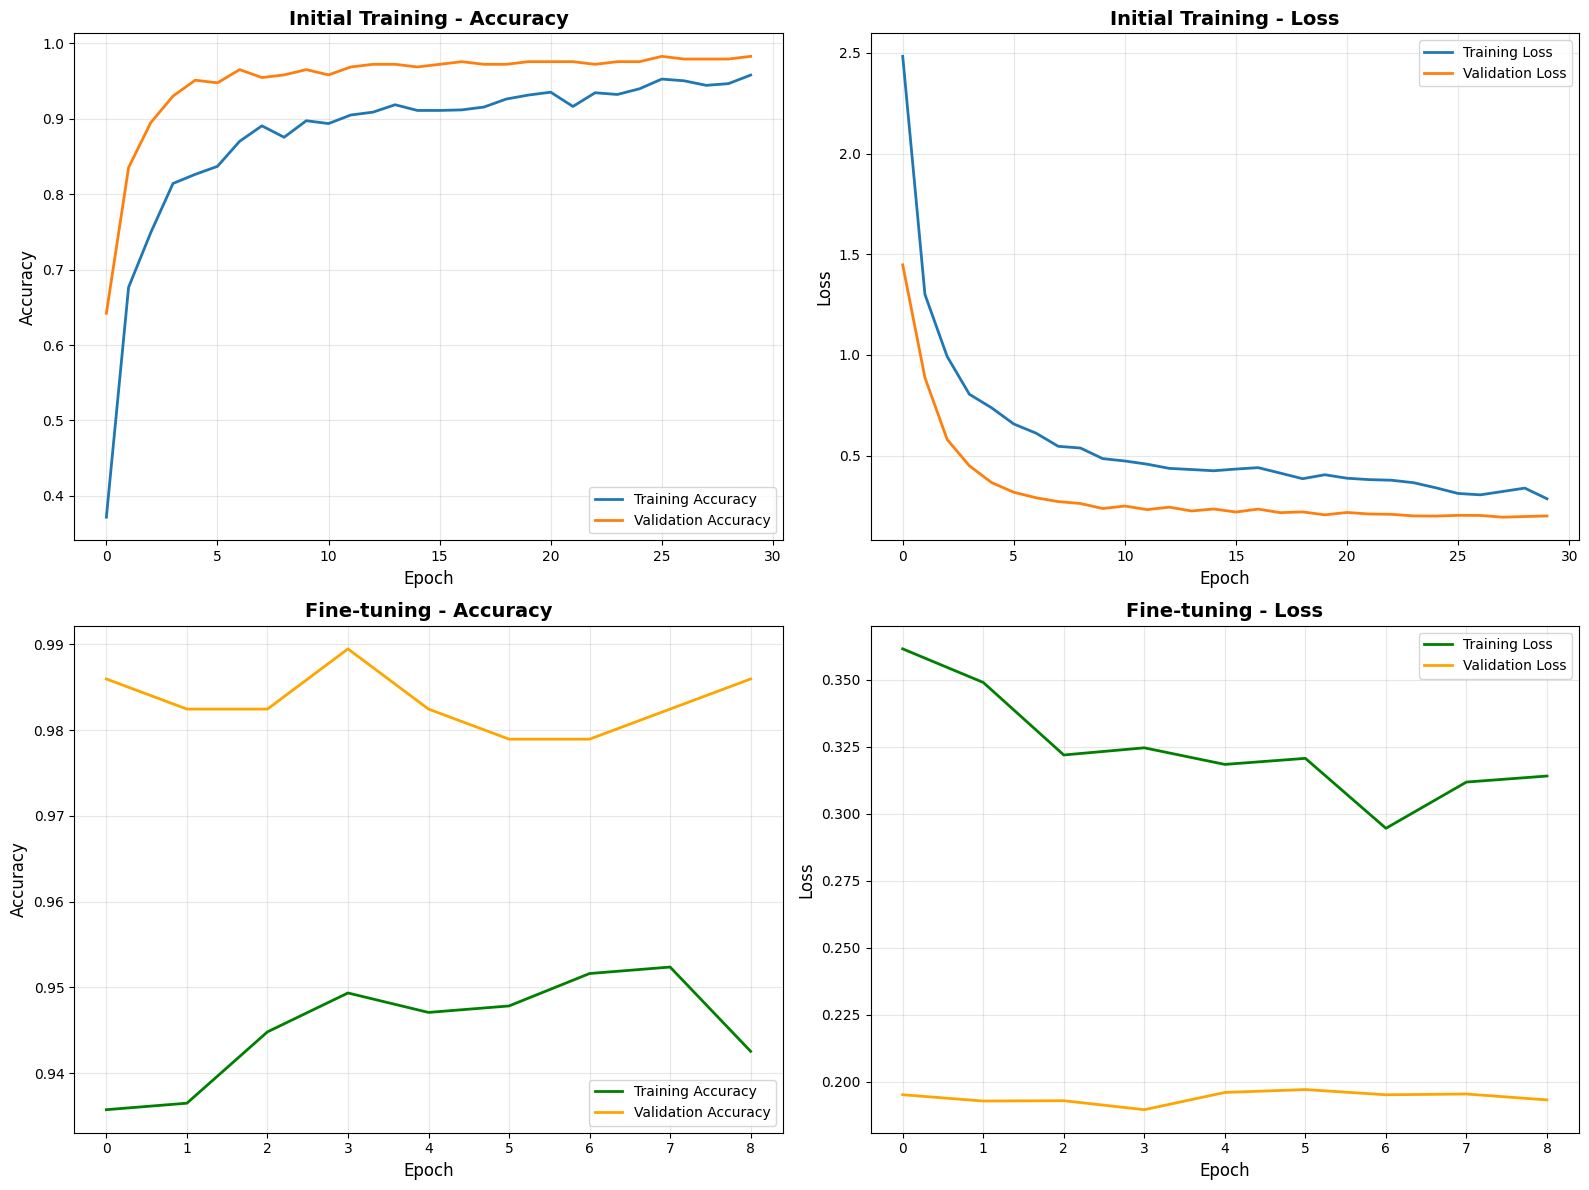


EVALUATING MODEL ON TEST SET
10/10 [==============================] - 15s 1s/step

TEST ACCURACY: 99.33%
PRECISION: 0.9940
RECALL: 0.9933
F1-SCORE: 0.9933

Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    0.9000    0.9474        10
           2     1.0000    1.0000    1.0000         8
           3     1.0000    1.0000    1.0000        10
           4     0.8889    1.0000    0.9412         8
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000         9
           7     1.0000    0.8889    0.9412         9
           8     1.0000    1.0000    1.0000        12
           9     1.0000    1.0000    1.0000        10
          10     1.0000    1.0000    1.0000        10
          11     1.0000    1.0000    1.0000        10
          12     1.0000    

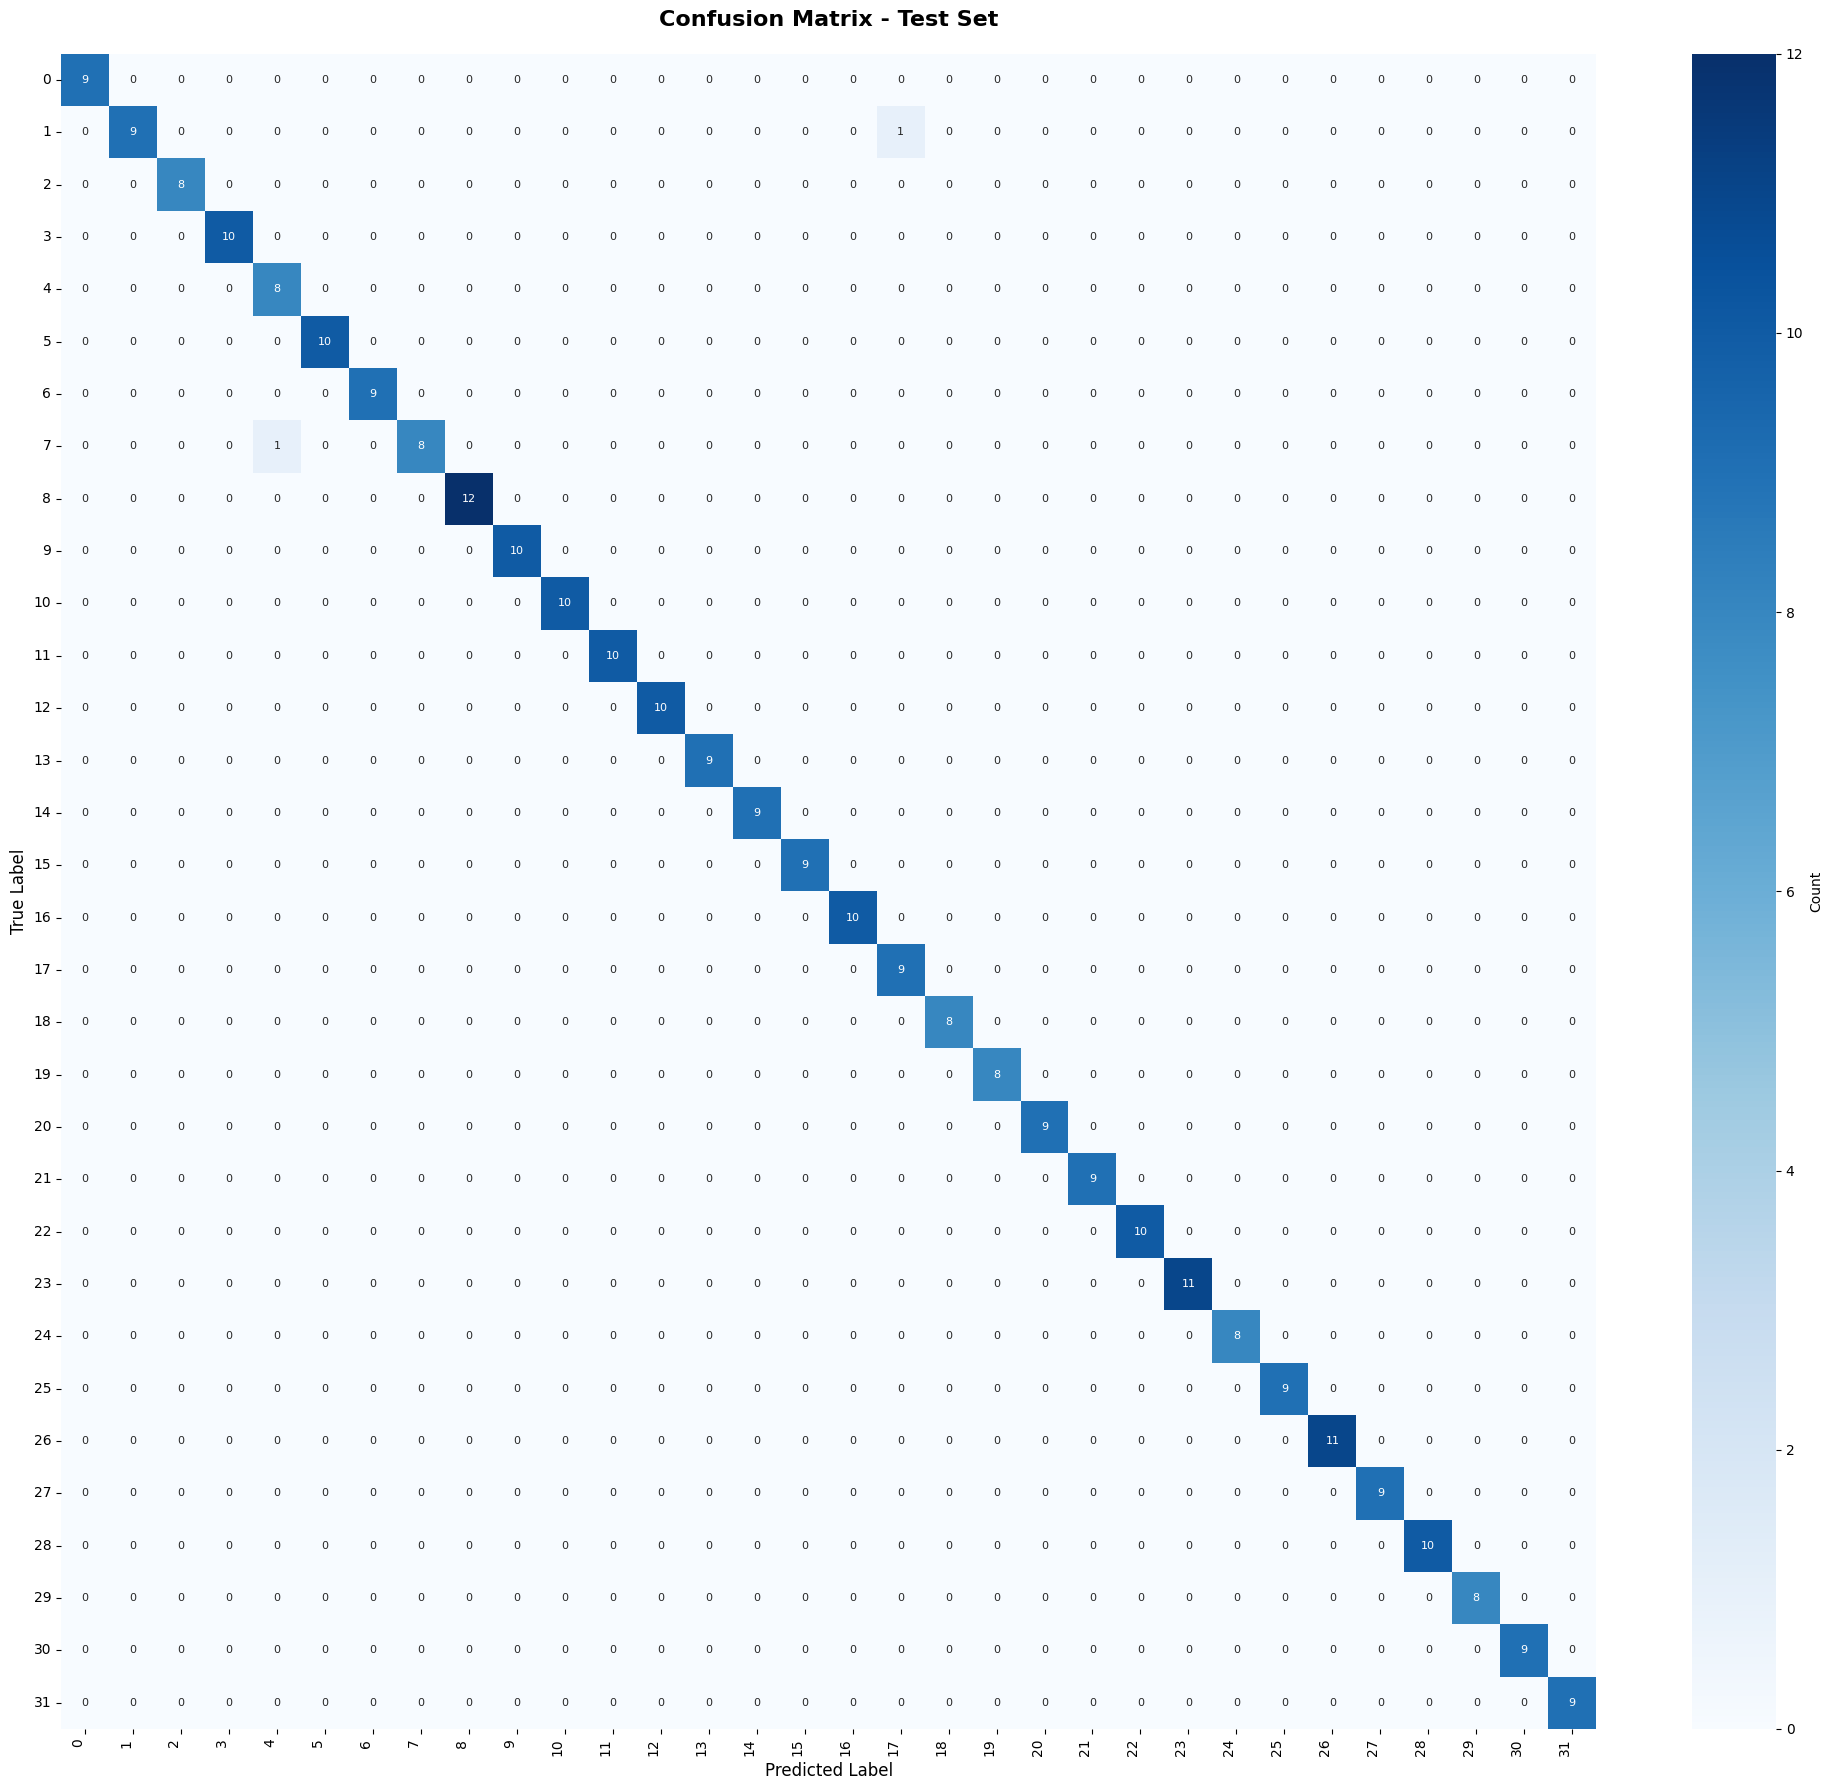

c:\Users\Mai\DeepFinal\tfenv_new\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



✓ Final model saved: inception_flavia_model.h5


████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█                            PIPELINE COMPLETE!                                 █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

  Model Type: Inception V3 (Transfer Learning)
  Final Test Accuracy: 99.33%
  Precision: 0.9940
  Recall: 0.9933
  F1-Score: 0.9933
  Total Classes: 32

████████████████████████████████████████████████████████████████████████████████



In [17]:
if __name__ == "__main__":
   
    CSV_PATH = '../Data/Leaves/all.csv'
    IMAGE_DIR = '../Data/Leaves'

    MODEL_TYPE = 'v3'

    print(f"\n{'='*80}")
    print(f"SELECTED MODEL: {MODEL_TYPE.upper()}")
    print(f"{'='*80}")
    if MODEL_TYPE.lower() == 'custom':
        print("Using: Custom Inception V1 built from scratch")
    else:
        print("Using: Pre-trained Inception V3 with Transfer Learning")
    print(f"{'='*80}\n")

    model, history, history_ft, classes = main_pipeline(CSV_PATH, IMAGE_DIR, model_type=MODEL_TYPE)